# Titanic - Machine Learning from Disaster
Start here! Predict survival on the Titanic and get familiar with ML basics  
kaggle: https://www.kaggle.com/c/titanic

## 環境設定
--------
## 環境設定
- GPU の使用状況を確認
- Google ドライブに接続
- パッケージ・ランダムシード設定

In [4]:
# GPU確認
!nvidia-smi

Sun Nov 26 23:08:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# 連接雲端硬碟
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabData/Titanic
#!unzip 'titanic.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabData/Titanic


In [6]:
# 套件，random seed
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm
import math
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.autograd import Variable
import time
import copy

Random_seed = 57
np.random.seed(Random_seed)
random.seed(Random_seed)
%matplotlib inline

## 讀檔、預處理
----------------------------
## データ準備
- データの読み込み
- データ全体の規模・変数を見る

### 讀檔
-------
### データの読み込み

In [ ]:
df_train = pd.read_csv('./raw/train.csv')
df_test = pd.read_csv('./raw/test.csv')
df_all = pd.concat([df_train, df_test])

### 資料大小、欄位資訊
-------
### データ全体の規模・変数を見る

In [ ]:
print('train data:', df_train.shape, ', test data:', df_test.shape)
print('Avg Survived Rate:', df_train['Survived'].mean())
df_train.info()

train data: (891, 12) , test data: (418, 11)
Avg Survived Rate: 0.3838383838383838
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### NA狀況
-------
### 欠損データの確認

In [ ]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## EDA

### カテゴリ変数により生存状況を確認
- 女性、ハイクラスの乗客の生存率が高い
- Cherbourgから乗船した人の生存率が高い
- 家族（兄弟、父母、子供）が一緒にいない人の生存率が低い

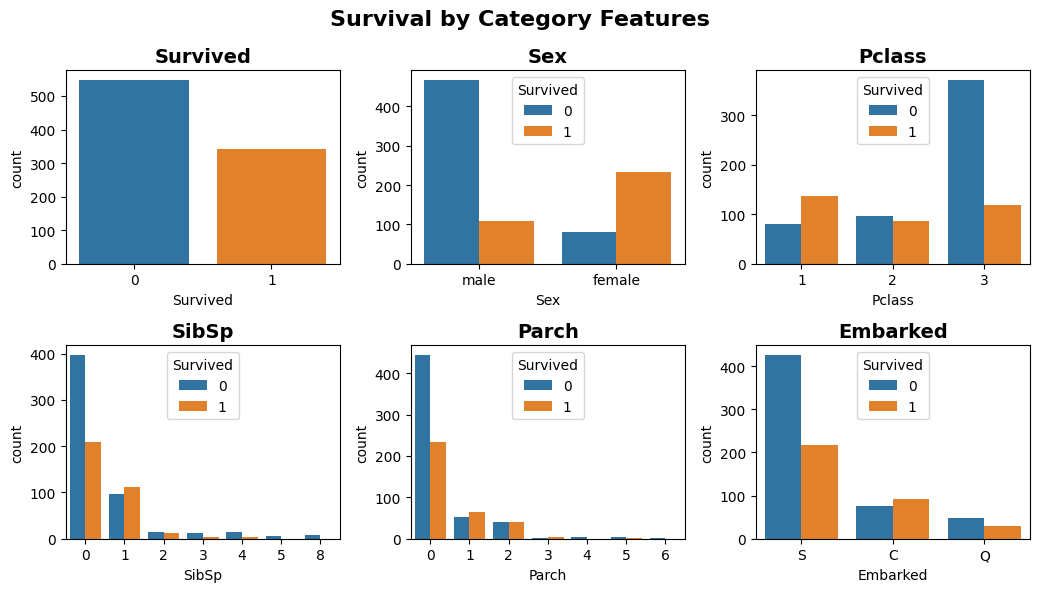

In [ ]:
cols = ['Survived', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
nr_rows = 2
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5, nr_rows*3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r * nr_cols + c
        ax = axs[r][c]
        if cols[i] != 'Survived':
            sns.countplot(x=cols[i], hue='Survived', data=df_train, ax=ax)
            ax.set_title(cols[i], fontsize=14, fontweight='bold')
            ax.legend(title="Survived", loc='upper center')
        else:
            sns.countplot(x=cols[i], data=df_train, ax=ax)
            ax.set_title(cols[i], fontsize=14, fontweight='bold')

fig.suptitle("Survival by Category Features", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('./img/Fig_EDA_1.png')
plt.show()

### 年齢・性別について生存状況を確認
- 10代後半から男性の生存率が低い
- 5~15歳の区間の女性生存率が比較的に低い
- 年齢と生存率の相関は単純な直線ではない ⇒ カテゴリ変数にする方が良い

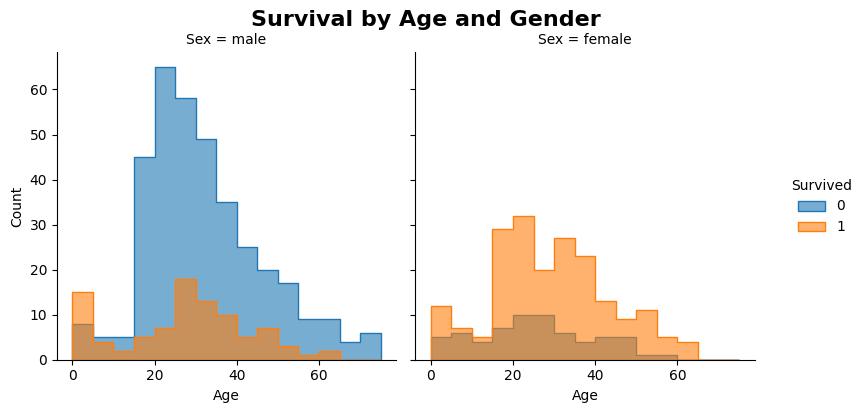

In [ ]:
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(df_train, col='Sex', hue='Survived', margin_titles=True, height=4, aspect=1.0)
g.map(sns.histplot, 'Age', bins=bins, alpha=0.6, kde=False, element="step")
g.add_legend()

plt.suptitle("Survival by Age and Gender", fontsize=16, fontweight='bold', y=1.02)
plt.savefig('./img/Fig_EDA_2.png')
plt.show()

### 更にPclassを考慮する
- 高いクラスの男性生存率が低いクラスよりも高い
- 低いクラスの女性生存率が高いクラスよりも低い

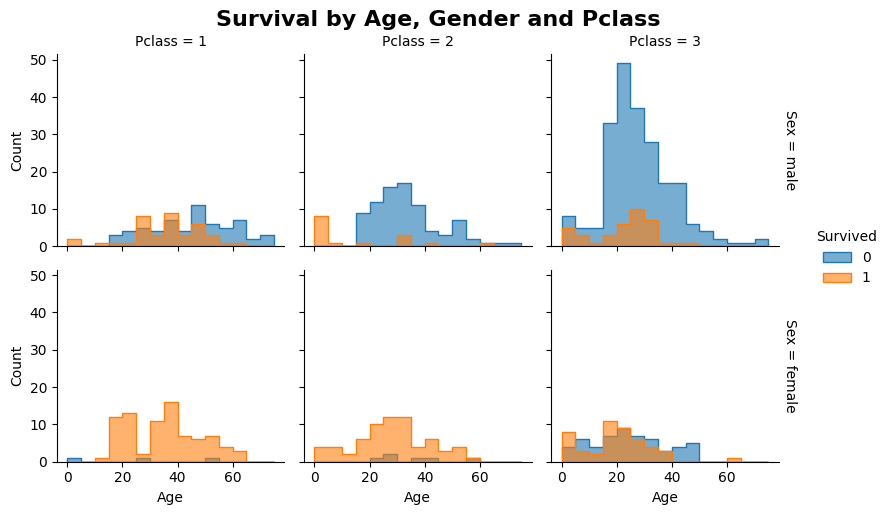

In [ ]:
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(df_train, row='Sex', col='Pclass', hue='Survived', margin_titles=True, height=2.5, aspect=1.1)
g.map(sns.histplot, 'Age', bins=bins, alpha=0.6, kde=False, element="step")
g.add_legend()

plt.suptitle("Survival by Age, Gender and Pclass", fontsize=16, fontweight='bold', y=1.02)
plt.savefig('./img/Fig_EDA_3.png')
plt.show()

### 運賃から見る場合
- Pclassから見るの結果とほぼ同じ

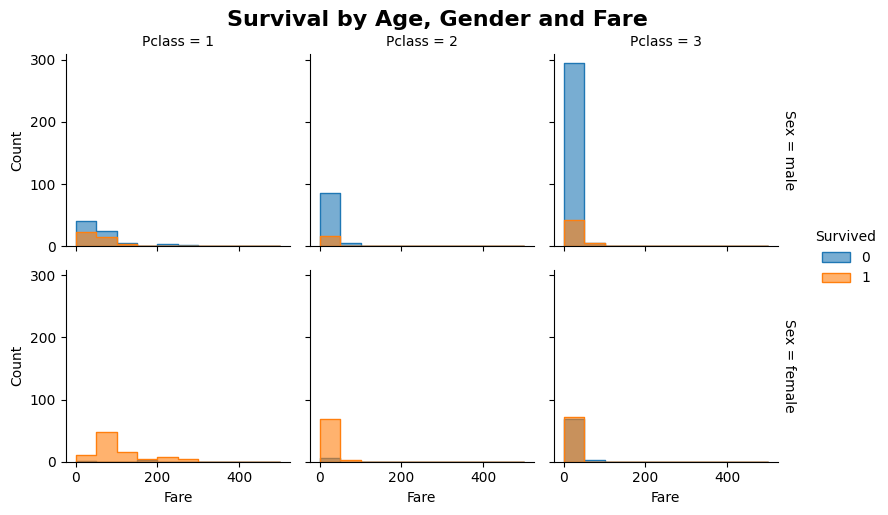

In [ ]:
bins = np.arange(0, 550, 50)
g = sns.FacetGrid(df_train, row='Sex', col='Pclass', hue='Survived', margin_titles=True, height=2.5, aspect=1.1)
g.map(sns.histplot, 'Fare', bins=bins, alpha=0.6, kde=False, element="step")
g.add_legend()

plt.suptitle("Survival by Age, Gender and Fare", fontsize=16, fontweight='bold', y=1.02)
plt.savefig('./img/Fig_EDA_4.png')
plt.show()

### 各変数の相関関係
- 相関係数
- ヒートマップで表示

In [ ]:
correlation_matrix = df_train.corr()
correlation_matrix

<ipython-input-50-5eb100c720da>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_train.corr()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


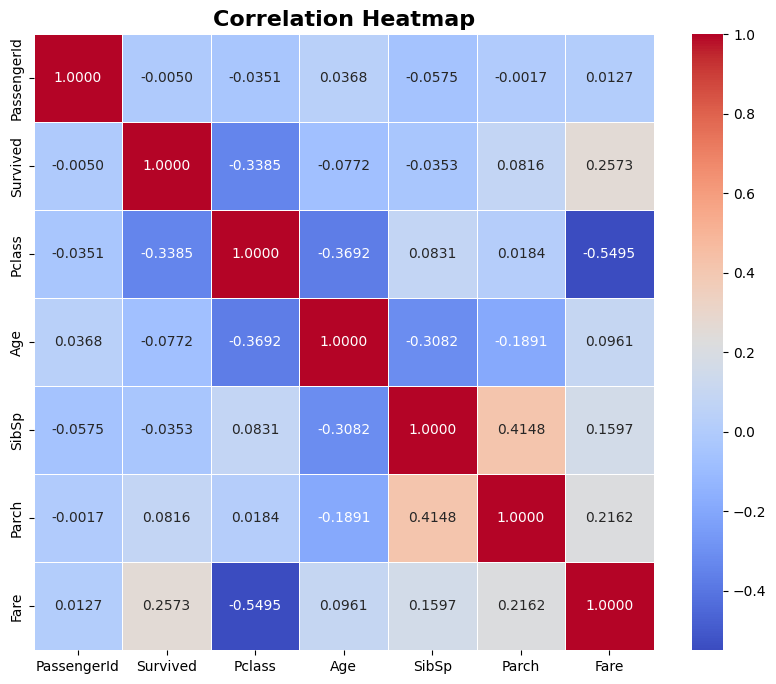

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5)

plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.savefig('./img/Fig_EDA_5.png')
plt.show()

## 特徴量エンジニアリング

### 欠損値を埋める
- Age: 年齢データなしの乗客の生存率は他の乗客よりも低い  
⇒ Age=NAのデータを保留する
- Cabin: 座席データの有無により生存率が異なる  
⇒ Cabin=NAのデータを保留する
- Embarked: 最頻値（訓練データの）で埋める
- Fare: 平均値（訓練データの）で埋める

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


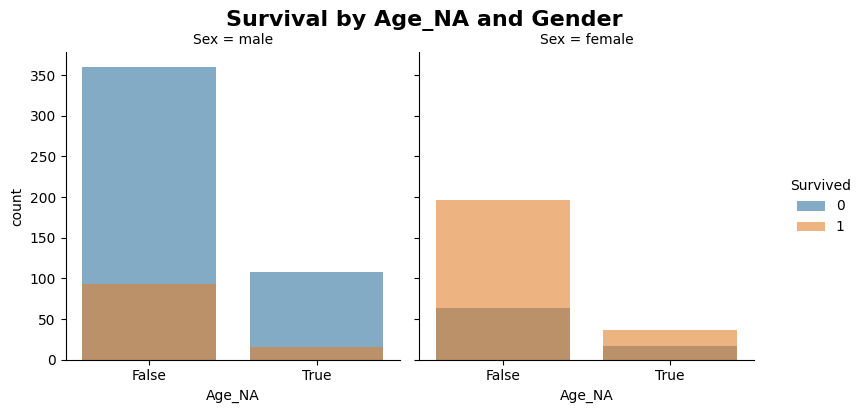

In [ ]:
# Age_NAにより生存状況を見る
df_train['Age_NA'] = df_train['Age'].isna()

g = sns.FacetGrid(df_train, col='Sex', hue='Survived', margin_titles=True, height=4, aspect=1.0)
g.map(sns.countplot, 'Age_NA', alpha=0.6)
g.add_legend()

plt.suptitle("Survival by Age_NA and Gender", fontsize=16, fontweight='bold', y=1.02)
plt.savefig('./img/Fig_FE_1.png')
plt.show()

# 欠損値を"NA"で埋める
df_train['Age'] = df_train['Age'].fillna('NA')
df_test['Age'] = df_test['Age'].fillna('NA')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


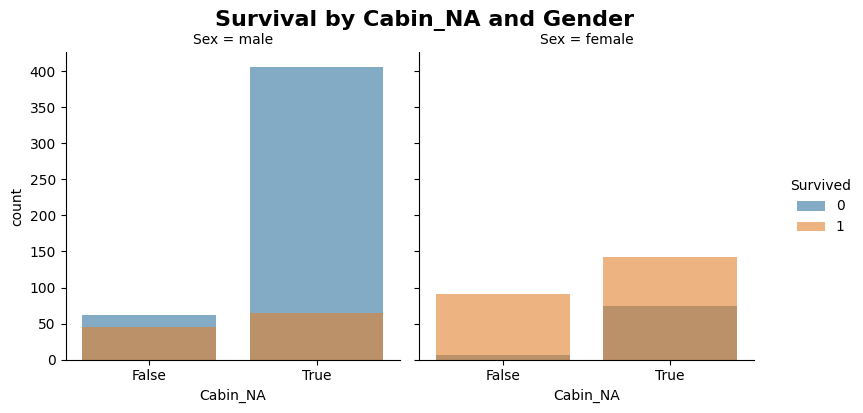

In [ ]:
#Cabin_NAにより生存状況を見る

df_train['Cabin_NA'] = df_train['Cabin'].isna()

g = sns.FacetGrid(df_train, col='Sex', hue='Survived', margin_titles=True, height=4, aspect=1.0)
g.map(sns.countplot, 'Cabin_NA', alpha=0.6)
g.add_legend()

plt.suptitle("Survival by Cabin_NA and Gender", fontsize=16, fontweight='bold', y=1.02)
plt.savefig('./img/Fig_FE_2.png')
plt.show()

# 欠損値を"NA"で埋める
df_train['Cabin'] = df_train['Cabin'].fillna('NA')
df_test['Cabin'] = df_test['Cabin'].fillna('NA')
df_test['Cabin_NA'] = df_test['Cabin'].isna()

### 年齢データをグループに分けて、ダミー変数にする

In [ ]:
def to_age_group(x):
  group = 'NA'
  if x == 'NA':
    group = 'NA'
  elif x < 5:
    group = '0-4'
  elif (x >= 5) & (x < 15):
    group = '5-14'
  elif (x >= 15) & (x < 20):
    group = '15-19'
  elif (x >= 20) & (x < 30):
    group = '20-29'
  elif (x >= 30) & (x < 40):
    group = '30-39'
  elif (x >= 40) & (x < 50):
    group = '40-49'
  elif (x >= 50) & (x < 60):
    group = '50-59'
  elif x >= 60:
    group = 'over60'
  return group

df_train['Age_group'] = df_train['Age'].apply(lambda x: to_age_group(x))
df_test['Age_group'] = df_test['Age'].apply(lambda x: to_age_group(x))

df_train = pd.get_dummies(df_train, columns=['Age_group'], prefix=['Age_group'])
df_test = pd.get_dummies(df_test, columns=['Age_group'], prefix=['Age_group'])

### 名前で身分を区分する
- 社会階級は乗客の生存率に影響する
- 乗客の名前から社会階級を判断できる
- 名前の長さ（単語数）
- 身分を表する単語（Mr., Ms., Dr.など）

In [ ]:
# 名前の長さ
df_train['Name_len'] = df_train['Name'].apply(lambda x : len(x.split()))
df_test['Name_len'] = df_test['Name'].apply(lambda x : len(x.split()))

#　身分に関する単語
for i in ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.', 'Rev.', 'Don.'] :
  df_train[i] = df_train['Name'].apply(lambda x : 1 if i in x else 0)
  df_test[i] = df_test['Name'].apply(lambda x : 1 if i in x else 0)

### その他
- fillna
- One-Hot Encoding

In [ ]:
# Embarked: 最頻値（訓練データの）で埋める
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

# Fare: 平均値（訓練データの）で埋める
df_test['Fare'] = df_test['Fare'].fillna(df_train['Fare'].mean())

# Sex をダミー変数に（Male）
for df in [df_train, df_test]:
  df['Male'] = df['Sex'].apply(lambda x : 1 if x == 'male' else 0)

# カテゴリ変数をダミー変数に(One-Hot Encoding)
cate_var = ['Pclass', 'Embarked']
df_train = pd.get_dummies(df_train, columns=cate_var, prefix=cate_var)
df_test = pd.get_dummies(df_test, columns=cate_var, prefix=cate_var)

### 前処理済のデータを保存
- 不要な特徴量を削除する
- ダミー変数の基準カテゴリ（ベース）を削除する(Pclass_3, Embarked_S, Age_group_NA)

In [ ]:
df_train = df_train.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Age_NA', 'Pclass_3', 'Embarked_S', 'Age_group_NA'], axis=1)
df_train.to_csv('train.csv', encoding = 'utf-8-sig', index=0)

df_test = df_test.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Pclass_3', 'Embarked_S', 'Age_group_NA'], axis=1)
df_test.to_csv('test.csv', encoding = 'utf-8-sig', index=0)

## 建模準備
-------
## モデル構築の準備
 - データサンプリング
 - 特徴量標準化

### データの読み込み・サンプリング
- ランダムに15%の訓練データを検証用のvalid dataにする

In [7]:
df_all = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train, df_valid = train_test_split(df_all, test_size=0.15, random_state=Random_seed)

### 特徴量の選択・標準化
- 訓練データを基に全ての特徴量を標準化する

In [8]:
# Ageの欠損値を平均値で埋める

Age_mean = df_train['Age'].mean()
df_train['Age'] = df_train['Age'].fillna(Age_mean)
df_valid['Age'] = df_valid['Age'].fillna(Age_mean)
df_all['Age'] = df_all['Age'].fillna(Age_mean)
df_test['Age'] = df_test['Age'].fillna(Age_mean)

In [9]:
# 特徴量の選択・標準化
sc = StandardScaler()
sc.fit(df_train.drop(columns=['PassengerId', 'Survived', 'Age']))

# training set
X_train = sc.transform(df_train.drop(columns=['PassengerId', 'Survived', 'Age'], axis=1))
y_train = df_train['Survived'].values

# validation set
X_valid = sc.transform(df_valid.drop(columns=['PassengerId', 'Survived', 'Age'], axis=1))
y_valid = df_valid['Survived'].values

# training + validation set
X_all = sc.transform(df_all.drop(columns=['PassengerId', 'Survived', 'Age'], axis=1))
y_all = df_all['Survived'].values

# test set
X_test = sc.transform(df_test.drop(columns=['PassengerId', 'Age'], axis=1))

### モデル結果記録の準備
- 使用したモデル
- 使用したデータ
- 予測結果の精度
- モデル訓練の所要時間
- 結果予測の所要時間

In [10]:
model_summary = pd.DataFrame({'Model':[], 'Acc_valid':[], 'Acc_test':[]})
#model_summary = pd.read_csv("output/model_summary.csv")
#model_summary.to_csv("output/model_summary.csv", index=0)
model_summary

,Model,Acc_valid,Acc_test


## 單一模型
-------
## モデル構築

 * Logistic
 * KNN（+GridSearch）
 * SVM（+GridSearch）
 * Decision Tree（+GridSearch）
 * Random Forest（+GridSearch）

### Logistic

In [11]:
# Logistic

model_name = 'Logistic'

def Logistic(X_train, X_valid, X_all, X_test, y_train, y_valid, y_all):
  model = LogisticRegression(fit_intercept = True, random_state = Random_seed)
  model.fit(X_train, y_train)

  y_pred_valid = model.predict(X_valid).astype(int)
  acc_valid = accuracy_score(y_valid, y_pred_valid)
  print('Valid Acc: {:.5f}'.format(acc_valid))

  model.fit(X_all, y_all)

  pred = model.predict(X_test).astype(int)
  df_test['Survived'] = pred
  df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/prediction/{}_{:.5f}.csv'.format(model_name, acc_valid), index = 0)

  df = pd.DataFrame({'Model':[model_name], 'Acc_valid':[acc_valid]})
  print('Completed.')
  return model, df

Logistic_model, df = Logistic(X_train, X_valid, X_all, X_test, y_train, y_valid, y_all)
model_summary = pd.concat([model_summary, df], ignore_index=True)
model_summary#.to_csv("output/model_summary.csv", index=0)

Valid Acc: 0.78358
Completed.


,Model,Acc_valid,Acc_test
0,Logistic,0.783582,NaN


### KNN

In [12]:
# Grid Search でハイパーパラメータを最適化する

def KNN_GS(X_train, y_train):

  param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
  model_grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring= 'accuracy')
  model_grid.fit(X_train, y_train)
  model = KNeighborsClassifier(**model_grid.best_params_)
  model.fit(X_train, y_train)

  print("best estimator: {}".format(model_grid.best_params_))
  return model

In [13]:
# KNN

model_name = 'KNN'

def KNN(model_name, model, X_valid, X_all, X_test, y_valid, y_all):
  y_pred_valid = model.predict(X_valid).astype(int)
  acc_valid = accuracy_score(y_valid, y_pred_valid)
  print('Valid Acc: {:.5f}'.format(acc_valid))

  model.fit(X_all, y_all)

  pred = model.predict(X_test).astype(int)
  df_test['Survived'] = pred
  df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/prediction/{}_{:.5f}.csv'.format(model_name, acc_valid), index = 0)

  df = pd.DataFrame({'Model':[model_name], 'Acc_valid':[acc_valid]})
  print('Completed.')
  return model, df

model = KNN_GS(X_train, y_train)
KNN_model, df = KNN(model_name, model, X_valid, X_all, X_test, y_valid, y_all)
model_summary = pd.concat([model_summary, df], ignore_index=True)
model_summary#.to_csv("output/model_summary.csv", index=0)

best estimator: {'n_neighbors': 9}
Valid Acc: 0.77612
Completed.


,Model,Acc_valid,Acc_test
0,Logistic,0.783582,NaN
1,KNN,0.776119,NaN


### SVM

In [14]:
# Grid Search でハイパーパラメータを最適化する

def SVM_GS(X_train, y_train):

  param_grid = {'C': [0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5],
          'kernel': ['linear', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto'],
          'random_state': [Random_seed]}
  model_grid = GridSearchCV(SVC(), param_grid, scoring= 'accuracy')
  model_grid.fit(X_train, y_train)
  model = SVC(**model_grid.best_params_)
  model.fit(X_train, y_train)

  print("best estimator: {}".format(model_grid.best_params_))
  return model

In [15]:
# SVM

model_name = 'SVM'

def SVM(model_name, model, X_valid, X_all, X_test, y_valid, y_all):
  y_pred_valid = model.predict(X_valid).astype(int)
  acc_valid = accuracy_score(y_valid, y_pred_valid)
  print('Valid Acc: {:.5f}'.format(acc_valid))

  model.fit(X_all, y_all)

  pred = model.predict(X_test).astype(int)
  df_test['Survived'] = pred
  df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/prediction/{}_{:.5f}.csv'.format(model_name, acc_valid), index = 0)

  df = pd.DataFrame({'Model':[model_name], 'Acc_valid':[acc_valid]})
  print('Completed.')
  return model, df

model = SVM_GS(X_train, y_train)
SVM_model, df = SVM(model_name, model, X_valid, X_all, X_test, y_valid, y_all)
model_summary = pd.concat([model_summary, df], ignore_index=True)

model_summary#.to_csv("output/model_summary.csv", index=0)

best estimator: {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 57}
Valid Acc: 0.80597
Completed.


,Model,Acc_valid,Acc_test
0,Logistic,0.783582,NaN
1,KNN,0.776119,NaN
2,SVM,0.805970,NaN


### Decision Tree

In [16]:
# Grid Search でハイパーパラメータを最適化する
def DT_GS(X_train, y_train):

  param_grid = {'criterion': ['gini', 'entropy'],
          'splitter': ['best'],
          'max_depth': [2, 3, 4, 5, 6],
          'min_samples_leaf': [3, 4, 5, 6, 7],
          'random_state': [Random_seed]}
  model_grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring= 'accuracy')
  model_grid.fit(X_train, y_train)
  model = DecisionTreeClassifier(**model_grid.best_params_)
  model.fit(X_train, y_train)

  print("best estimator: {}".format(model_grid.best_params_))
  return model

In [17]:
# Decision Tree
model_name = 'DTree'

def DTree(model_name, model, X_valid, X_all, X_test, y_valid, y_all):
  y_pred_valid = model.predict(X_valid).astype(int)
  acc_valid = accuracy_score(y_valid, y_pred_valid)
  print('Valid Acc: {:.5f}'.format(acc_valid))

  model.fit(X_all, y_all)

  pred = model.predict(X_test).astype(int)
  df_test['Survived'] = pred
  df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/prediction/{}_{:.5f}.csv'.format(model_name, acc_valid), index = 0)

  df = pd.DataFrame({'Model':[model_name], 'Acc_valid':[acc_valid]})
  print('Completed.')
  return model, df

model = DT_GS(X_train, y_train)
DTree_model, df = DTree(model_name, model, X_valid, X_all, X_test, y_valid, y_all)
model_summary = pd.concat([model_summary, df], ignore_index=True)

model_summary#.to_csv("output/model_summary.csv", index=0)

best estimator: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 7, 'random_state': 57, 'splitter': 'best'}
Valid Acc: 0.79104
Completed.


,Model,Acc_valid,Acc_test
0,Logistic,0.783582,NaN
1,KNN,0.776119,NaN
2,SVM,0.805970,NaN
3,DTree,0.791045,NaN


### Random Forest

In [18]:
# Grid Search でハイパーパラメータを最適化する
def RF_GS(X_train, y_train):

  param_grid = {'n_estimators': [50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [2, 3, 4, 5, 6],
          'min_samples_leaf': [4, 5, 6, 8],
          'random_state': [Random_seed],
          }
  model_grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring= 'accuracy')
  model_grid.fit(X_train, y_train)
  model = RandomForestClassifier(**model_grid.best_params_)
  model.fit(X_train, y_train)

  print("best estimator: {}".format(model_grid.best_params_))
  return model

In [19]:
# Random Forest
model_name = 'RForest'

def RForest(model_name, model, X_valid, X_all, X_test, y_valid, y_all):
  y_pred_valid = model.predict(X_valid).astype(int)
  acc_valid = accuracy_score(y_valid, y_pred_valid)
  print('Valid Acc: {:.5f}'.format(acc_valid))

  model.fit(X_all, y_all)

  pred = model.predict(X_test).astype(int)
  df_test['Survived'] = pred
  df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/prediction/{}_{:.5f}.csv'.format(model_name, acc_valid), index = 0)

  df = pd.DataFrame({'Model':[model_name], 'Acc_valid':[acc_valid]})
  print('Completed.')
  return model, df

model = RF_GS(X_train, y_train)
RForest_model, df = RForest(model_name, model, X_valid, X_all, X_test, y_valid, y_all)
model_summary = pd.concat([model_summary, df], ignore_index=True)

model_summary#.to_csv("output/model_summary.csv", index=0)

best estimator: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 50, 'random_state': 57}
Valid Acc: 0.80597
Completed.


,Model,Acc_valid,Acc_test
0,Logistic,0.783582,NaN
1,KNN,0.776119,NaN
2,SVM,0.805970,NaN
3,DTree,0.791045,NaN
4,RForest,0.805970,NaN


## 集成模型
-------
## ブレンド方法
 * Voting
 * Stacking

In [20]:
model_list = [('Logistic', Logistic_model), ('KNN', Logistic_model), ('SVM', Logistic_model), ('DTree', Logistic_model), ('RForest', Logistic_model)]

### Voting

In [21]:
# Grid Search でハイパーパラメータを最適化する
def Voting_GS(X_train, y_train, model_list):

  param_grid = {'estimators': [model_list],
          'voting': ['hard', 'soft']}

  model_grid = GridSearchCV(VotingClassifier(model_list), param_grid, scoring= 'accuracy')
  model_grid.fit(X_train, y_train)
  model = VotingClassifier(**model_grid.best_params_)
  model.fit(X_train, y_train)

  print("best estimator: {}".format(model_grid.best_params_))
  return model

In [22]:
# Voting
model_name = 'Voting'

def Voting(model_name, model, X_valid, X_all, X_test, y_valid, y_all):
  y_pred_valid = model.predict(X_valid).astype(int)
  acc_valid = accuracy_score(y_valid, y_pred_valid)
  print('Valid Acc: {:.5f}'.format(acc_valid))

  model.fit(X_all, y_all)

  pred = model.predict(X_test).astype(int)
  df_test['Survived'] = pred
  df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/prediction/{}_{:.5f}.csv'.format(model_name, acc_valid), index = 0)

  df = pd.DataFrame({'Model':[model_name], 'Acc_valid':[acc_valid]})
  print('Completed.')
  return model, df

model = Voting_GS(X_train, y_train, model_list)
Voting_model, df = Voting(model_name, model, X_valid, X_all, X_test, y_valid, y_all)
model_summary = pd.concat([model_summary, df], ignore_index=True)

model_summary#.to_csv("output/model_summary.csv", index=0

best estimator: {'estimators': [('Logistic', LogisticRegression(random_state=57)), ('KNN', LogisticRegression(random_state=57)), ('SVM', LogisticRegression(random_state=57)), ('DTree', LogisticRegression(random_state=57)), ('RForest', LogisticRegression(random_state=57))], 'voting': 'hard'}
Valid Acc: 0.78358
Completed.


,Model,Acc_valid,Acc_test
0,Logistic,0.783582,NaN
1,KNN,0.776119,NaN
2,SVM,0.805970,NaN
3,DTree,0.791045,NaN
4,RForest,0.805970,NaN
5,Voting,0.783582,NaN


### Stacking

In [23]:
# Grid Search でハイパーパラメータを最適化する
def Stacking_GS(X_train, y_train, model_list):

  param_grid = {'estimators': [model_list],
          'final_estimator': [LogisticRegression(fit_intercept = True, random_state = Random_seed),
                    SVC(random_state = Random_seed)]}

  model_grid = GridSearchCV(StackingClassifier(model_list), param_grid, scoring= 'accuracy')
  model_grid.fit(X_train, y_train)
  model = StackingClassifier(**model_grid.best_params_)
  model.fit(X_train, y_train)

  print("best estimator: {}".format(model_grid.best_params_))
  return model

In [24]:
# Stacking
model_name = 'Stacking'

def Stacking(model_name, model, X_valid, X_all, X_test, y_valid, y_all):
  y_pred_valid = model.predict(X_valid).astype(int)
  acc_valid = accuracy_score(y_valid, y_pred_valid)
  print('Valid Acc: {:.5f}'.format(acc_valid))

  model.fit(X_all, y_all)

  pred = model.predict(X_test).astype(int)
  df_test['Survived'] = pred
  df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/prediction/{}_{:.5f}.csv'.format(model_name, acc_valid), index = 0)

  df = pd.DataFrame({'Model':[model_name], 'Acc_valid':[acc_valid]})
  print('Completed.')
  return model, df

model = Stacking_GS(X_train, y_train, model_list)
Stacking_model, df = Stacking(model_name, model, X_valid, X_all, X_test, y_valid, y_all)
model_summary = pd.concat([model_summary, df], ignore_index=True)

model_summary#.to_csv("output/model_summary.csv", index=0

best estimator: {'estimators': [('Logistic', LogisticRegression(random_state=57)), ('KNN', LogisticRegression(random_state=57)), ('SVM', LogisticRegression(random_state=57)), ('DTree', LogisticRegression(random_state=57)), ('RForest', LogisticRegression(random_state=57))], 'final_estimator': LogisticRegression(random_state=57)}
Valid Acc: 0.78358
Completed.


,Model,Acc_valid,Acc_test
0,Logistic,0.783582,NaN
1,KNN,0.776119,NaN
2,SVM,0.805970,NaN
3,DTree,0.791045,NaN
4,RForest,0.805970,NaN
5,Voting,0.783582,NaN
6,Stacking,0.783582,NaN


## Pytorch: NN model
-------
## Neural Networkモデル
 -  Model:　Linear + Dropout + ReLU + sigmoid
 - optimizer: (1)SGD + momentum + weight_decay、(2)Adam、(3)AdamW
 - ブレンド：Voting

### Neural Network Model

In [39]:
# Model

class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 240),
            nn.ReLU(),
            nn.Linear(240, 600),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(600, 240),
            nn.ReLU(),
            nn.Linear(240, 2)
        )

    def forward(self, x):
        net_x = self.net(x)
        net_x = torch.sigmoid(net_x)
        #print(net_x)
        return net_x

### Hyper-parameters

In [40]:
# Hyper-parameters

learning_rate = 0.0001
momentum = 0.95
weight_decay = 0.0001
batch_size = 20
n_jobs = 4
n_epochs = 5000
patience = 1000
save_path = 'models/NN.pth'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer_i = 2

### Data
 * Dataset
 * DataLoader


In [28]:
# Dataset

class DataSet(Dataset):
  def __init__(self, X, Y):

    self.X = X
    self.Y = Y
    self.length = len(X)

  def __len__(self):

    return self.length

  def __getitem__(self, index):

    x = self.X[index]
    y = self.Y[index]

    return x, y

In [29]:
# DataLoader

trainset = DataSet(X_train, y_train)
trainallset = DataSet(X_all, y_all)

trainloader = DataLoader(trainset, batch_size = batch_size, num_workers = n_jobs, shuffle = True)
trainallloader = DataLoader(trainallset, batch_size = batch_size, num_workers = n_jobs, shuffle = True)

### Train & Predict

In [41]:
# Train

model = NeuralNet(X_train.shape[1])
optimizers = [torch.optim.AdamW(model.parameters(), lr = learning_rate),
        torch.optim.Adam(model.parameters(), lr = learning_rate),
        torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)]
optimizer = optimizers[optimizer_i]

best_acc = 0
best_epochs = n_epochs
early_stop = False
early_stop_cnt = 0
since = time.time()
for epoch in range(n_epochs):

  model.train()
  for data in trainloader:

      x, y = data[0].float(), data[1].long()

      optimizer.zero_grad()
      output = model(x)
      _, pred = torch.max(output, 1)

      loss = criterion(output, y)
      loss.backward()
      optimizer.step()

  train_acc = accuracy_score(y, pred)


  model.eval()
  with torch.no_grad():
    out = model(torch.tensor(X_valid).float())
    _, pred = torch.max(out, 1)

  valid_acc = accuracy_score(torch.tensor(y_valid), pred)

  print('Epoch {}/{}'.format(epoch+ 1, n_epochs))
  print('Train Acc: {:.8f}, Valid Acc: {:.8f}'.format(train_acc, valid_acc))

  if valid_acc > best_acc:
    best_acc = valid_acc
    best_epochs = epoch
    torch.save(model.state_dict(), save_path)

    print('Saving The Model')
    early_stop_cnt = 0
  else:
    print("Counter {} of {}".format(early_stop_cnt+ 1, patience))
    early_stop_cnt += 1

  print('-' * 10)

  if early_stop_cnt >= patience:
    print("Early stop!")
    early_stop = True

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:.8f}, epoch {}'.format(best_acc, best_epochs))
    break

if early_stop == False:

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best valid Acc: {:.8f}'.format(best_acc))

串流輸出內容已截斷至最後 5000 行。
----------
Epoch 647/5000
Train Acc: 0.82352941, Valid Acc: 0.79104478
Counter 449 of 1000
----------
Epoch 648/5000
Train Acc: 0.82352941, Valid Acc: 0.79104478
Counter 450 of 1000
----------
Epoch 649/5000
Train Acc: 0.82352941, Valid Acc: 0.79104478
Counter 451 of 1000
----------
Epoch 650/5000
Train Acc: 0.70588235, Valid Acc: 0.79104478
Counter 452 of 1000
----------
Epoch 651/5000
Train Acc: 0.94117647, Valid Acc: 0.79104478
Counter 453 of 1000
----------
Epoch 652/5000
Train Acc: 1.00000000, Valid Acc: 0.79104478
Counter 454 of 1000
----------
Epoch 653/5000
Train Acc: 0.94117647, Valid Acc: 0.79104478
Counter 455 of 1000
----------
Epoch 654/5000
Train Acc: 0.76470588, Valid Acc: 0.79104478
Counter 456 of 1000
----------
Epoch 655/5000
Train Acc: 0.94117647, Valid Acc: 0.79104478
Counter 457 of 1000
----------
Epoch 656/5000
Train Acc: 0.88235294, Valid Acc: 0.79104478
Counter 458 of 1000
----------
Epoch 657/5000
Train Acc: 0.64705882, Valid Acc: 0.7910447

In [42]:
# Valid acc

model = NeuralNet(X_train.shape[1])
model.load_state_dict(torch.load("models/NN.pth"))

model.eval()
with torch.no_grad():
  out = model(torch.tensor(X_valid).float())
  _, pred = torch.max(out, 1)

valid_acc = accuracy_score(torch.tensor(y_valid), pred)
print('Valid_Acc :', valid_acc)

Valid_Acc : 0.8134328358208955


In [43]:
# Train with all data

model = NeuralNet(X_train.shape[1])
model.load_state_dict(torch.load("models/NN.pth"))
optimizer = optimizers[optimizer_i]

since = time.time()
for epoch in range(best_epochs):

  model.train()
  for data in trainallloader:

      x, y = data[0].float(), data[1].long()

      optimizer.zero_grad()
      output = model(x)
      _, pred = torch.max(output, 1)

      loss = criterion(output, y)
      loss.backward()
      optimizer.step()

torch.save(model.state_dict(), "models/NN_all.pth")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training complete in 6m 29s


In [44]:
# Predict

model = NeuralNet(X_train.shape[1])
model.load_state_dict(torch.load("models/NN_all.pth"))

model.eval()
with torch.no_grad():
  out = model(torch.tensor(X_test).float())
  _, pred = torch.max(out, 1)

df_test['Survived'] = pred.squeeze().detach().numpy().astype(int)
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/Torch_opt{}_{}.csv'.format(optimizer_i, valid_acc), index = 0)

### Voting

In [46]:
# Voting

df1 = pd.read_csv('./output/Torch_opt0_0.84328.csv')
df2 = pd.read_csv('./output/Torch_opt1_0.83582.csv')
df3 = pd.read_csv('./output/Torch_opt2_0.81343.csv')
df_Torch = df1
df_Torch['Survived1'] = df1['Survived']
df_Torch['Survived2'] = df2['Survived']
df_Torch['Survived3'] = df3['Survived']

df_Torch['Survived1'] = df_Torch.loc[:, ['Survived1', 'Survived2', 'Survived3']].mode(axis = 1)
df_Torch.loc[:, ['PassengerId', 'Survived']].to_csv('./output/prediction/Torch_Vote.csv', index = 0)